In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [2]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [3]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()

def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

In [87]:
video_path = './data/11.mp4'
write_path = './movie.avi'

# free_kick

In [96]:
free_kick = cv2.VideoCapture(video_path)
if free_kick.isOpened():
    print('Film wczytany!')

free_kick_width = int(free_kick.get(3))
free_kick_height = int(free_kick.get(4))

print(free_kick_height, free_kick_width)

free_kick_fps = free_kick.get(cv2.CAP_PROP_FPS)
print(free_kick_fps)
Video.from_file(video_path)

Film wczytany!
1080 1920
30.0


Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

In [97]:
free_kick.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = free_kick.read()

# get balls bounding b
old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(old_gray,cv2.HOUGH_GRADIENT,1,18, param1=80,param2=10,minRadius=10,maxRadius=20)
circles = np.uint16(np.around(circles))
x = circles[circles[...,0]>170]
x = x[x[...,0]<1760]
x = x[x[...,1]>135]
x = x[x[...,1]<920]
circles = x.reshape(1,  x.shape[0], 3)

# player_bbox = (190, 260, 70, 100)
# gkeeper_bbox = (375, 55, 60, 80)
balls = []
for circle in circles[0, :]:
    balls.append((circle[0]-circle[2], circle[1]-circle[2], 2*circle[2], 2*circle[2]))

# player_tracker = create_tracker('CSRT')
# gkeeper_tracker = create_tracker('CSRT')

# if player_tracker.init(frame, player_bbox):
#   print('Algorytm śledządzy piłkarza zainicjalizowany w punkcie:', player_bbox)

# if gkeeper_tracker.init(frame, gkeeper_bbox):
#   print('Algorytm śledządzy bramkarza zainicjalizowany w punkcie:', gkeeper_bbox)
balls_tracker = []
for ball_box in balls:
    balls_tracker.append(create_tracker('CSRT'))
    balls_tracker[-1].init(frame, ball_box)

free_kick_track = cv2.VideoWriter(write_path, cv2.VideoWriter_fourcc(*'DIVX'), free_kick_fps, (free_kick_width, free_kick_height))

free_kick.set(cv2.CAP_PROP_POS_FRAMES, 0)
while free_kick.isOpened():
    ret, frame = free_kick.read()
    
    if ret:
        frame[...,0] = cv2.GaussianBlur(frame[...,0],(3,3),0)
        frame[...,1] = cv2.GaussianBlur(frame[...,1],(3,3),0)
        frame[...,2] = cv2.GaussianBlur(frame[...,2],(3,3),0)
        for tracker in balls_tracker:
            ok, bbox = tracker.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))


        free_kick_track.write(frame)
    else:
        break

free_kick_track.release()

In [98]:
!ffmpeg -hide_banner -loglevel error -i movie.avi -y movie.mp4

In [99]:
Video.from_file('./movie.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0e\x0e\xc4mdat\x0…

# Ruch optyczny

In [45]:
traffic = cv2.VideoCapture(video_path)
if traffic.isOpened():
    print('Film wczytany!')

traffic_width = int(traffic.get(3))
traffic_height = int(traffic.get(4))

print(traffic_height, traffic_width)

traffic_fps = traffic.get(cv2.CAP_PROP_FPS)
print(traffic_fps)

Film wczytany!
1080 1920
30.0


In [47]:
Video.from_file(video_path)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05\xa8ae\…

In [48]:
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)
lk_params = dict(winSize=(15,15),
                 maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0,255,(100,3))

In [49]:
traffic.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, old_frame = traffic.read()

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
####################################################################### NEW
circles = cv2.HoughCircles(old_gray,cv2.HOUGH_GRADIENT,1,18, param1=80,param2=10,minRadius=10,maxRadius=20)
circles = np.uint16(np.around(circles))
x = circles[circles[...,0]>170]
x = x[x[...,0]<1760]
x = x[x[...,1]>135]
x = x[x[...,1]<920]
circles = x.reshape(1,  x.shape[0], 3)
p0 = circles[...,:2].reshape(circles.shape[1],1,2).astype('float')

#######################################################################
mask = np.zeros_like(old_frame)

In [50]:
p0 = p0.astype('float32')

In [51]:
traffic_optical_flow = cv2.VideoWriter(write_path, cv2.VideoWriter_fourcc(*'DIVX'), traffic_fps, (traffic_width, traffic_height))

traffic.set(cv2.CAP_PROP_POS_FRAMES, 0)
while traffic.isOpened():
    ret, frame = traffic.read()
    if ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_gray = cv2.GaussianBlur(frame_gray,(3,3),0)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)

        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)

        traffic_optical_flow.write(cv2.add(frame, mask))
    else:
        break

traffic_optical_flow.release()

In [52]:
!ffmpeg -hide_banner -loglevel error -i movie.avi -y movie.mp4

In [53]:
Video.from_file('./movie.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\r\x19@mdat\x00\x00…

# Circles

Znalezionych okręgów: 16


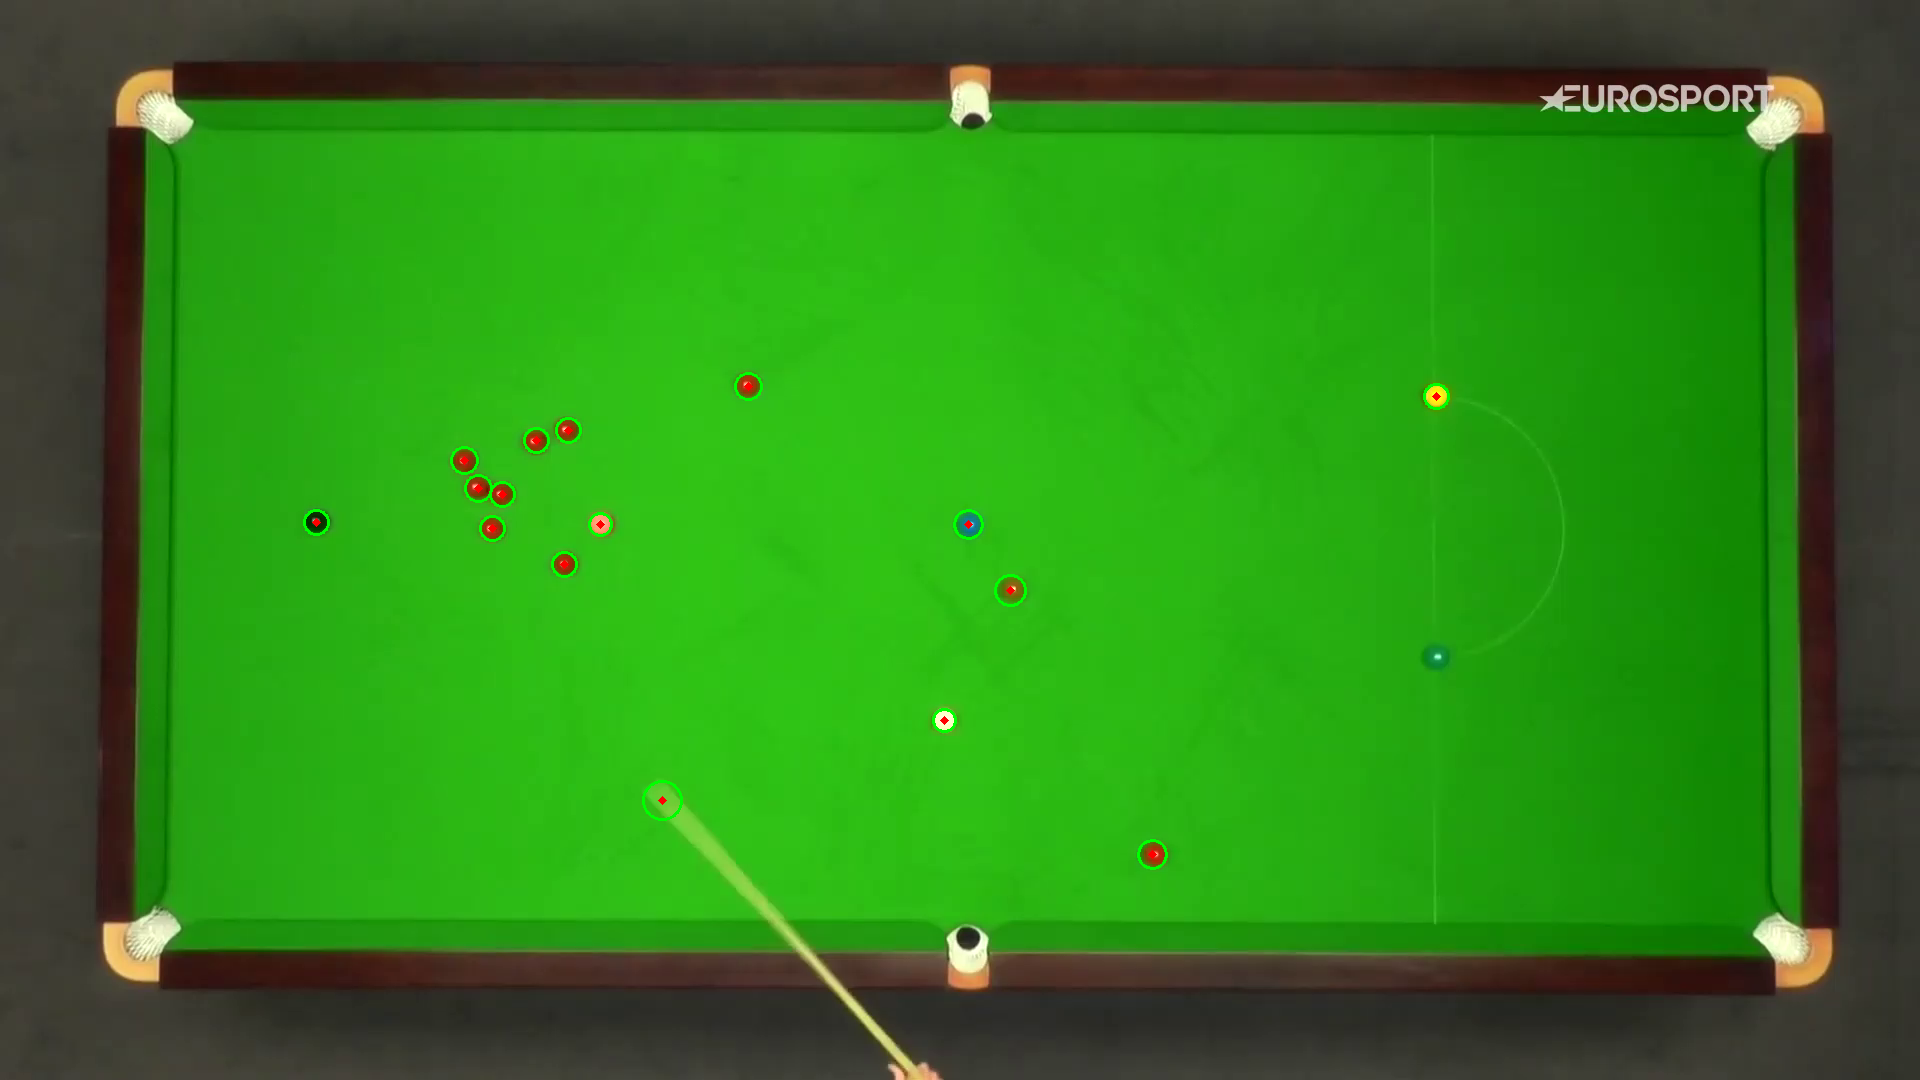

In [161]:
traffic.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, old_frame = traffic.read()

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
mask = np.zeros_like(old_frame)

skittles_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
# sharpen
#skittles_gray = cv2.GaussianBlur(skittles_gray,(3,3),0)

# circles = cv2.HoughCircles(skittles_gray, cv2.HOUGH_GRADIENT, 1, 50, param1=70, param2=10, minRadius=6, maxRadius=20)
circles = cv2.HoughCircles(skittles_gray,cv2.HOUGH_GRADIENT,1,18, param1=80,param2=10,minRadius=10,maxRadius=20)
circles = np.uint16(np.around(circles))
x = circles[circles[...,0]>170]
x = x[x[...,0]<1760]
x = x[x[...,1]>135]
x = x[x[...,1]<920]
circles = x.reshape(1,  x.shape[0], 3)


p0 = circles[...,:2].reshape(circles.shape[1],1,2)
print('Znalezionych okręgów:', len(circles[0]))
for i in circles[0, :]:
    cv2.circle(old_frame,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(old_frame,(i[0],i[1]),2,(0,0,255),3)
imshow(old_frame)

In [135]:
i

968

In [137]:
circles.shape

(1, 56, 3)

In [44]:
circles[...,:2].reshape(circles.shape[1],1,2)

array([[[1644,   98]],

       [[ 968,  954]],

       [[1788,  944]],

       [[1778,  114]],

       [[ 968,  100]],

       [[1716,   98]],

       [[ 160,  114]],

       [[ 142,  940]],

       [[1774,  124]],

       [[ 162,  934]],

       [[ 332,  454]],

       [[ 968,  938]],

       [[ 172,  118]],

       [[ 534,  442]],

       [[1436,  396]],

       [[1764,  122]],

       [[ 152,  106]],

       [[ 584,  856]],

       [[ 572,  480]],

       [[ 406,  490]],

       [[ 446,  534]],

       [[ 498,  492]],

       [[1778,  940]],

       [[1668,   96]],

       [[ 530,  506]],

       [[1742,  104]],

       [[ 972,  112]],

       [[ 622,  574]],

       [[ 600,  524]],

       [[ 612,  672]],

       [[1758,  100]],

       [[ 464,  512]],

       [[1780,   94]],

       [[1784,  104]],

       [[ 598,  698]],

       [[1152,  854]],

       [[1790,  116]],

       [[ 370,  422]],

       [[ 588,  670]],

       [[1594,  100]],

       [[ 146,  930]],

       [[1772,  